                                                           Mini-Project-2

## Workflow
The computation entails the following steps.

1.Select the dimensions of study (L in m; t in Days); Q will be 
m3/d and BU = Ti = m2/d
2.Select projection to use. Albers Equal Area Conic CONUS, NAD 83 (2011); EPSG:6350
3.Select the Well Location (get lat-lon coordinates) convert to AEA projection
4.Extract Transmissivity values at the well (from interpolated T gpkg file)
5.Obtain the mean water levels (computed earlier) for wells in a gpkg fle
6.Convert the meam water levels file to AEA projection and compute X and Y coordinates
7.Compute the regional groundwater flow using linear regression of Hydraulic Head (from MSL) against X and Y
8.Use the coefficients of X and Y to obtain the gradients along X and Y axis and compute resultant gradient
9.Compute the capture zone polygon in model coordinates (well is at 0,0)
10.Convert the capture zone polygon to AEA projection coordinates use suitable transformation
11.Transform the coordinates obtained in the above step such that X-axis is oriented along the groundwater flow direction
12.Create a shapely polygon (object) of the capture zone. Export to a gpkg file
13.Overlay the capture zone polygon onto the Jefferson County Map; Embellish the plot as appropriate.

In [ ]:
# Load Libraries
import pandas as pd
import geopandas as gpd
import os
from shapely.geometry import Point, Polygon
from shapely.affinity import rotate
import matplotlib.pyplot as plt
from pyproj import Transformer
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
Set Working Directory

In [ ]:
path = "D:\\Mini-project-2"
os.chdir(path)

In [20]:
# Load CSV data
gcmeanwell_df = pd.read_csv('gcmeanwell.csv')
pumpwell_df = pd.read_csv('pumpwell_jef.csv')
tvalues_df = pd.read_csv('Tvalues.csv')

In [21]:
# Step 1: Define the study parameters (L, t, Q, BU)
L = 1000  # Length in meters
t = 365  # Time in days (e.g., one year)
Q = 500  # Discharge in m^3/d
BU = 1.5  # Transmissivity in m^2/d

In [ ]:
# Step 2: Select the projection to use
aea_projection = "EPSG:6350"  # Albers Equal Area Conic

In [ ]:
# Step 3: Convert well location data to GeoDataFrame and project to AEA
gcmeanwell_gdf = gpd.GeoDataFrame(
    gcmeanwell_df,
    geometry=gpd.points_from_xy(gcmeanwell_df['LongitudeDD'], gcmeanwell_df['LatitudeDD']),
    crs="EPSG:4326"  # WGS84
).to_crs(aea_projection)


In [ ]:
# Step 4: Extract transmissivity values
tvalues_gdf = gpd.GeoDataFrame(
    tvalues_df,
    geometry=gpd.points_from_xy(tvalues_df['Lon'], tvalues_df['Lat']),
    crs="EPSG:4326"
).to_crs(aea_projection)

In [ ]:
# Step 5: Obtain the mean water levels from the gcmeanwell dataset
mean_water_level = gcmeanwell_df['WaterElevation'].mean()

In [ ]:
# Step 6: Convert the mean water levels file to AEA and compute X, Y coordinates
gcmeanwell_gdf['X'] = gcmeanwell_gdf.geometry.x
gcmeanwell_gdf['Y'] = gcmeanwell_gdf.geometry.y

In [ ]:
import pandas as pd

# Load the CSV file
csv_file = r"D:\Mini-project-2\gcmeanwell.csv"
df = pd.read_csv(csv_file)

# Print the column names to check the available fields
print(df.columns)

In [ ]:
# Assuming the correct column names are 'longitude' and 'latitude'
geometry = [Point(xy) for xy in zip(df['LongitudeDD'], df['LatitudeDD'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Set the coordinate reference system (CRS) to match your data's CRS (e.g., WGS84)
gdf.set_crs("EPSG:4326", inplace=True)

# Print the GeoDataFrame to check the result
print(gdf.head())

In [24]:
# Step 7: Compute regional groundwater flow using linear regression of hydraulic head against X and Y
X = gcmeanwell_gdf[['X', 'Y']]
y = gcmeanwell_gdf['WaterElevation']
reg_model = LinearRegression().fit(X, y)
gradient_x, gradient_y = reg_model.coef_

# Step 8: Compute the resultant gradient
resultant_gradient = np.sqrt(gradient_x**2 + gradient_y**2)

# Step 9: Compute the capture zone polygon in model coordinates
capture_zone = Polygon([
    (gcmeanwell_gdf.geometry.x.mean() - L/2, gcmeanwell_gdf.geometry.y.mean() - L/2),
    (gcmeanwell_gdf.geometry.x.mean() + L/2, gcmeanwell_gdf.geometry.y.mean() - L/2),
    (gcmeanwell_gdf.geometry.x.mean() + L/2, gcmeanwell_gdf.geometry.y.mean() + L/2),
    (gcmeanwell_gdf.geometry.x.mean() - L/2, gcmeanwell_gdf.geometry.y.mean() + L/2)
])
capture_zone_gdf = gpd.GeoDataFrame(geometry=[capture_zone], crs=aea_projection)

C:\Users\munta\AppData\Local\Temp\ipykernel_7304\4283683663.py:21: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right')


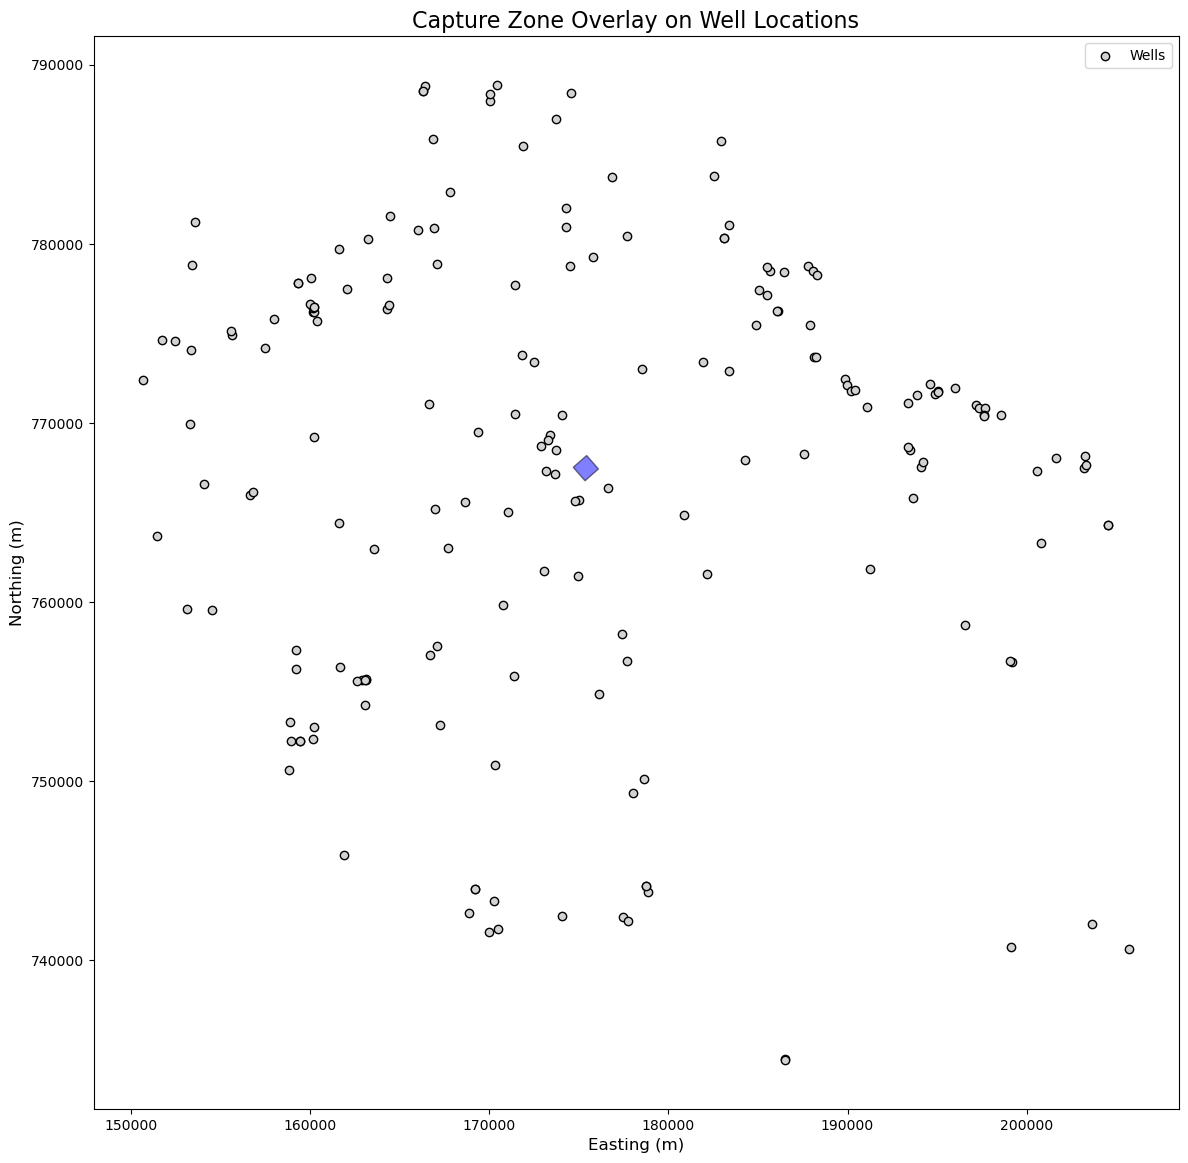

In [27]:
# Step 10: Ensure the capture zone polygon is in AEA projection (already set)
capture_zone_gdf = capture_zone_gdf.to_crs(aea_projection)


# Step 11: Transform coordinates to align X-axis with groundwater flow
angle_degrees = np.degrees(np.arctan2(gradient_y, gradient_x))  # Convert angle to degrees
capture_zone_gdf['geometry'] = capture_zone_gdf['geometry'].apply(lambda geom: rotate(geom, angle_degrees, origin='center', use_radians=False))

# Step 12: Export the capture zone polygon to a GeoPackage
capture_zone_gdf.to_file('capture_zone_output.gpkg', driver='GPKG')

# Step 13: Overlay the capture zone onto the Jefferson County map and embellish the plot
fig, ax = plt.subplots(figsize=(14, 14))
gcmeanwell_gdf.plot(ax=ax, color='lightgray', edgecolor='black', label='Wells')
capture_zone_gdf.plot(ax=ax, color='blue', alpha=0.5, edgecolor='black', label='Capture Zone')

# Add plot details
plt.title('Capture Zone Overlay on Well Locations', fontsize=16)
plt.xlabel('Easting (m)', fontsize=12)
plt.ylabel('Northing (m)', fontsize=12)
plt.legend(loc='upper right')

# Show the plot
plt.show()